# Import Library

In [46]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression

# Data Preparation

In [47]:
# Importing Data
df = pd.read_csv('healtcare_stroke_data.csv')
def one_hot_encode(df):
    """
    One-hot encodes all object data type columns of a Pandas DataFrame.
    """
    # Get the object columns
    obj_cols = df.select_dtypes(include=['object']).columns
    # One-hot encode the object columns
    df = pd.get_dummies(df, columns=obj_cols)
    return df

df = one_hot_encode(df).fillna(0)
df.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,False,True,False,...,False,True,False,False,False,True,False,True,False,False
1,51676,61.0,0,0,202.21,0.0,1,True,False,False,...,False,False,True,False,True,False,False,False,True,False
2,31112,80.0,0,1,105.92,32.5,1,False,True,False,...,False,True,False,False,True,False,False,False,True,False
3,60182,49.0,0,0,171.23,34.4,1,True,False,False,...,False,True,False,False,False,True,False,False,False,True
4,1665,79.0,1,0,174.12,24.0,1,True,False,False,...,False,False,True,False,True,False,False,False,True,False


In [48]:
df_model = df[['age','hypertension','heart_disease','bmi','stroke','gender_Male','smoking_status_smokes', 'avg_glucose_level']].reset_index()


# Defining Variable
treatment = 'smoking_status_smokes'
outcome = 'stroke'
features = {'age':5, 'avg_glucose_level':2, 'bmi':6,}

df_model.head()

,index,age,hypertension,heart_disease,bmi,stroke,gender_Male,smoking_status_smokes,avg_glucose_level
0,0,67.0,0,1,36.6,1,True,False,228.69
1,1,61.0,0,0,0.0,1,False,False,202.21
2,2,80.0,0,1,32.5,1,True,False,105.92
3,3,49.0,0,0,34.4,1,False,True,171.23
4,4,79.0,1,0,24.0,1,False,False,174.12


# Coarsening Feature

In [49]:
def coarse(input_df,input_feature,treatment,outcome):
    df_in_coarse = input_df[features.keys()].copy().reset_index()
        
    for i in input_feature.keys():
        df_in_coarse[i] = pd.cut(df[i], bins=input_feature[i], right=False)
        
    df_all = pd.merge(input_df,df_in_coarse,on=['index'],how='left',suffixes=('_ori', '_bin'))
    return df_all

In [50]:
df_coarse = coarse(df_model,features,treatment,outcome)
df_coarse

,index,age_ori,hypertension,heart_disease,bmi_ori,stroke,gender_Male,smoking_status_smokes,avg_glucose_level_ori,age_bin,avg_glucose_level_bin,bmi_bin
0,0,67.0,0,1,36.6,1,True,False,228.69,"[65.616, 82.082)","[163.43, 271.957)","[32.533, 48.8)"
1,1,61.0,0,0,0.0,1,False,False,202.21,"[49.232, 65.616)","[163.43, 271.957)","[0.0, 16.267)"
2,2,80.0,0,1,32.5,1,True,False,105.92,"[65.616, 82.082)","[55.12, 163.43)","[16.267, 32.533)"
3,3,49.0,0,0,34.4,1,False,True,171.23,"[32.848, 49.232)","[163.43, 271.957)","[32.533, 48.8)"
4,4,79.0,1,0,24.0,1,False,False,174.12,"[65.616, 82.082)","[163.43, 271.957)","[16.267, 32.533)"
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,5105,80.0,1,0,0.0,0,False,False,83.75,"[65.616, 82.082)","[55.12, 163.43)","[0.0, 16.267)"
5106,5106,81.0,0,0,40.0,0,False,False,125.20,"[65.616, 82.082)","[55.12, 163.43)","[32.533, 48.8)"
5107,5107,35.0,0,0,30.6,0,False,False,82.99,"[32.848, 49.232)","[55.12, 163.43)","[16.267, 32.533)"
5108,5108,51.0,0,0,25.6,0,True,False,166.29,"[49.232, 65.616)","[163.43, 271.957)","[16.267, 32.533)"


# Distribution Plot Before Matching

In [51]:
def kde_plot(input_data, input_features, treatment, label_treatment={0: 'Non Takers', 1: 'Takers'}):
    df_viz = pd.melt(input_data, id_vars=treatment, value_name='value') 

    df_viz_no_outliers = {}
    for i in input_features:
        mask = df_viz['variable'] == i
        df_viz_mask = df_viz[mask].copy()

        # Filtering percentile 0.05 and 0.95 each variable
        lower_bound = df_viz_mask['value'].quantile(0.05)
        upper_bound = df_viz_mask['value'].quantile(0.95)
        no_outliers = (df_viz_mask['value'] >= lower_bound) & (df_viz_mask['value'] <= upper_bound)
        data_no_outliers = df_viz_mask[no_outliers]

        # Scaling relative to Max after filter percentile
        max_value = data_no_outliers['value'].max()
        data_no_outliers['scaled_value'] = data_no_outliers['value']/max_value
        
        # Colecting Pandas each Variable
        df_viz_no_outliers[i] = data_no_outliers


    df_viz_final = pd.concat(df_viz_no_outliers.values())
    mask = df_viz_final['variable'].isin(input_features)

    df_viz_final['Treatment'] = df_viz_final[treatment].apply(lambda x: label_treatment[x])

    # plot distribution
    sns.set_theme(style='white')
    sns.catplot(data=df_viz_final[mask], x="variable", y="scaled_value", hue="Treatment", kind='violin',
                   split=True, inner="quart", palette="muted", height=4, aspect=2, legend_out=False)
    plt.xlabel('')
    plt.ylabel('Scaled Value')
    plt.legend(loc='upper right', fontsize='small')
    plt.show()

C:\Users\Lenovo V14-G2\AppData\Local\Temp\ipykernel_23724\2416855513.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_outliers['scaled_value'] = data_no_outliers['value']/max_value
C:\Users\Lenovo V14-G2\AppData\Local\Temp\ipykernel_23724\2416855513.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_outliers['scaled_value'] = data_no_outliers['value']/max_value
C:\Users\Lenovo V14-G2\AppData\Local\Temp\ipykernel_23724\2416855513.py:17: SettingWithCopyWarning: 
A value is trying to be s

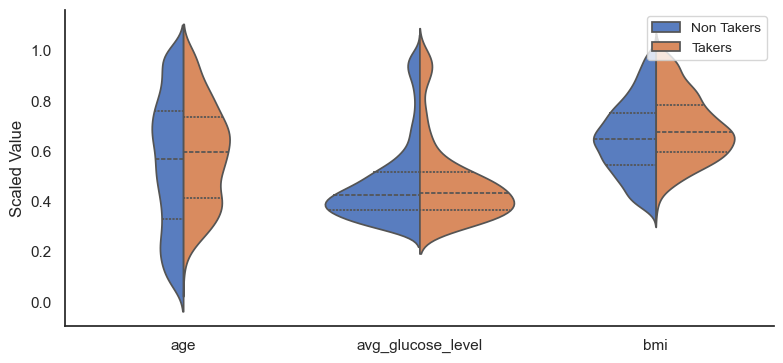

In [53]:
feature_kde_bef = ['age','avg_glucose_level','bmi']
kde_plot(df,feature_kde_bef,treatment)

# Matching Treatment & Control

In [54]:
def matching(input_df,input_feature,treatment,outcome):
    df = input_df.copy().drop(columns=[outcome,'index'], errors='ignore')
    
    # all possibilities of class combination
    signature = df.filter(like='_bin', axis=1)
    list_col_sig = list(signature.columns)
    df_signature = signature.groupby(list_col_sig)
    df_signature = df_signature.apply(lambda x: x.reset_index(drop=True)).reset_index(drop=True)

    # get total row for treatment and control that match each other
    count_rows = lambda df: df.groupby(list(signature.columns)).size().reset_index(name=f'total_row_match')
    label = df[treatment]==1
    
    match_treatment = count_rows(df[label])
    match_control = count_rows(df[~label])

    result_match = pd.merge(match_treatment, match_control, on=list_col_sig, how='left', suffixes=('_treatment', '_control'))

    result_match = result_match[(result_match['total_row_match_treatment'] != 0) & (result_match['total_row_match_control'] != 0)]
    
    # calculate weight ATT
    weight_t_att = 1
    weight_c_att = (result_match['total_row_match_treatment']/result_match['total_row_match_control'])*(sum(result_match['total_row_match_control'])/sum(result_match['total_row_match_treatment']))
    
    result_match['weight_t_att'] = weight_t_att
    result_match['weight_c_att'] = weight_c_att
    
    # calculate weight atc
    weight_t_atc = (result_match['total_row_match_control']/result_match['total_row_match_treatment'])*(sum(result_match['total_row_match_treatment'])/sum(result_match['total_row_match_control']))
    weight_c_atc = 1
    
    result_match['weight_t_atc'] = weight_t_atc
    result_match['weight_c_atc'] = weight_c_atc
    
    # calculate weight ate
    weight_t_ate = (result_match['total_row_match_control']+result_match['total_row_match_treatment'])/(result_match['total_row_match_treatment']*(1+(sum(result_match['total_row_match_control'])/sum(result_match['total_row_match_treatment']))))
    weight_c_ate = (result_match['total_row_match_control']+result_match['total_row_match_treatment'])/(result_match['total_row_match_control']*(1+(sum(result_match['total_row_match_treatment'])/sum(result_match['total_row_match_control']))))
    
    result_match['weight_t_ate'] = weight_t_ate
    result_match['weight_c_ate'] = weight_c_ate
    
    # join result match to preliminary data
    result_match_treatment = pd.merge(df[label],result_match,on=list_col_sig,how='inner').drop(columns=['total_row_match_treatment','total_row_match_control','weight_c_att','weight_c_atc','weight_c_ate'])
    result_match_treatment.rename(columns = {'weight_t_att':'weight','weight_t_atc':'weight_atc','weight_t_ate':'weight_ate'}, inplace = True)
    
    result_match_control = pd.merge(df[~label],result_match,on=list_col_sig,how='inner').drop(columns=['total_row_match_treatment','total_row_match_control','weight_t_att','weight_t_atc','weight_t_ate'])
    result_match_control.rename(columns = {'weight_c_att':'weight','weight_c_atc':'weight_atc','weight_c_ate':'weight_ate'}, inplace = True) 
    
    result_match_all = pd.concat([result_match_treatment, result_match_control], ignore_index=True)
    
    # add weighted feature
    feature_weighted = result_match_all.filter(like='_ori', axis=1).columns

    for i in feature_weighted:
        new_col_name = f"{i}_weighted"
        result_match_all[new_col_name] = result_match_all[i] * result_match_all['weight'] 
    
    return result_match_all

In [55]:
df_matched = matching(df_coarse,features.keys(),treatment,outcome)
df_matched

C:\Users\Lenovo V14-G2\AppData\Local\Temp\ipykernel_23724\646944005.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_signature = signature.groupby(list_col_sig)
C:\Users\Lenovo V14-G2\AppData\Local\Temp\ipykernel_23724\646944005.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_rows = lambda df: df.groupby(list(signature.columns)).size().reset_index(name=f'total_row_match')
C:\Users\Lenovo V14-G2\AppData\Local\Temp\ipykernel_23724\646944005.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain c

,age_ori,hypertension,heart_disease,bmi_ori,gender_Male,smoking_status_smokes,avg_glucose_level_ori,age_bin,avg_glucose_level_bin,bmi_bin,weight,weight_atc,weight_ate,age_ori_weighted,bmi_ori_weighted,avg_glucose_level_ori_weighted
0,49.0,0,0,34.4,False,True,171.23,"[32.848, 49.232)","[163.43, 271.957)","[32.533, 48.8)",1.000000,0.514394,0.591451,49.000000,34.400000,171.230000
1,49.0,0,0,43.8,True,True,186.32,"[32.848, 49.232)","[163.43, 271.957)","[32.533, 48.8)",1.000000,0.514394,0.591451,49.000000,43.800000,186.320000
2,41.0,0,0,35.2,False,True,229.86,"[32.848, 49.232)","[163.43, 271.957)","[32.533, 48.8)",1.000000,0.514394,0.591451,41.000000,35.200000,229.860000
3,42.0,0,1,34.2,False,True,226.93,"[32.848, 49.232)","[163.43, 271.957)","[32.533, 48.8)",1.000000,0.514394,0.591451,42.000000,34.200000,226.930000
4,44.0,0,0,41.8,False,True,215.90,"[32.848, 49.232)","[163.43, 271.957)","[32.533, 48.8)",1.000000,0.514394,0.591451,44.000000,41.800000,215.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4942,25.0,0,0,35.8,False,False,181.30,"[16.464, 32.848)","[163.43, 271.957)","[32.533, 48.8)",7.069214,1.000000,1.963075,176.730361,253.077877,1281.648577
4943,47.0,0,0,0.0,True,False,237.17,"[32.848, 49.232)","[163.43, 271.957)","[0.0, 16.267)",7.952866,1.000000,2.103295,373.784713,0.000000,1886.181287
4944,47.0,0,0,0.0,False,False,195.61,"[32.848, 49.232)","[163.43, 271.957)","[0.0, 16.267)",7.952866,1.000000,2.103295,373.784713,0.000000,1555.660166
4945,42.0,0,0,0.0,True,False,177.91,"[32.848, 49.232)","[163.43, 271.957)","[0.0, 16.267)",7.952866,1.000000,2.103295,334.020382,0.000000,1414.894433


In [56]:
df_matched.describe()

,age_ori,hypertension,heart_disease,bmi_ori,avg_glucose_level_ori,weight,weight_atc,weight_ate,age_ori_weighted,bmi_ori_weighted,avg_glucose_level_ori_weighted
count,4947.000000,4947.000000,4947.000000,4947.000000,4947.000000,4947.000000,4947.000000,4947.000000,4947.000000,4947.000000,4947.000000
mean,44.319313,0.099454,0.055791,27.998747,106.328310,1.000000,1.000000,1.000000,46.929860,28.511094,106.212051
std,22.027332,0.299301,0.229542,9.102949,45.534261,0.546646,0.821375,0.696460,27.068833,18.008437,85.194049
min,0.080000,0.000000,0.000000,0.000000,55.120000,0.033932,0.125741,0.264470,0.002715,0.000000,1.878149
25%,27.000000,0.000000,0.000000,23.300000,77.175000,0.771187,1.000000,0.868236,31.329473,19.896625,71.389572
50%,46.000000,0.000000,0.000000,27.800000,91.960000,1.185700,1.000000,1.029467,50.000000,29.879641,100.220000
75%,61.000000,0.000000,0.000000,32.800000,114.090000,1.297276,1.000000,1.047172,62.654126,37.992765,128.612195
max,82.000000,1.000000,1.000000,64.800000,271.740000,7.952866,29.470507,24.952749,373.784713,342.856900,1886.181287


# Before and After Matching Evaluation

In [57]:
feature_ori = df_coarse.filter(like='_ori', axis=1).columns

for var in feature_ori:
    print(f"{var} | Before matching")
    display(df_coarse.groupby(treatment)[var].describe())

age_ori | Before matching


,count,mean,std,min,25%,50%,75%,max
smoking_status_smokes,,,,,,,,
False,4321.0,42.520019,23.502093,0.08,23.0,44.0,61.0,82.0
True,789.0,47.096324,16.413002,10.00,33.0,47.0,59.0,82.0


bmi_ori | Before matching


,count,mean,std,min,25%,50%,75%,max
smoking_status_smokes,,,,,,,,
False,4321.0,27.615436,9.378945,0.0,22.6,27.5,32.6,97.6
True,789.0,28.530545,10.287074,0.0,24.7,28.7,34.1,78.0


avg_glucose_level_ori | Before matching


,count,mean,std,min,25%,50%,75%,max
smoking_status_smokes,,,,,,,,
False,4321.0,105.806265,44.906548,55.12,77.29,91.63,113.87,267.76
True,789.0,108.017440,47.280803,55.32,77.19,93.88,114.47,271.74


In [58]:
feature_weighted = df_matched.filter(like='_weighted', axis=1).columns

for var in feature_weighted:
    print(f"{var} | after matching")
    display(df_matched.groupby(treatment)[var].describe())

age_ori_weighted | after matching


,count,mean,std,min,25%,50%,75%,max
smoking_status_smokes,,,,,,,,
False,4162.0,46.878188,28.64197,0.002715,30.076294,50.83539,62.875351,373.784713
True,785.0,47.203822,16.38361,10.000000,33.000000,47.00000,59.000000,82.000000


bmi_ori_weighted | after matching


,count,mean,std,min,25%,50%,75%,max
smoking_status_smokes,,,,,,,,
False,4162.0,28.498746,19.147314,0.0,18.480894,30.452248,38.973865,342.8569
True,785.0,28.576561,10.006272,0.0,24.700000,28.700000,34.100000,61.6000


avg_glucose_level_ori_weighted | after matching


,count,mean,std,min,25%,50%,75%,max
smoking_status_smokes,,,,,,,,
False,4162.0,105.928728,90.609024,1.878149,68.130542,102.112983,130.635975,1886.181287
True,785.0,107.714204,47.033165,55.320000,77.190000,93.730000,114.340000,271.740000


# SMD

In [59]:
def smd(input_df,feature,treatment):
    agg_dict = {}
    agg_dict.update({x : ['mean', 'std'] for x in feature})
    
    table_agg = input_df.groupby(treatment).agg(agg_dict).reset_index()
    
    
    smd_val = []
    for i in feature:
        mean_1 = table_agg[i].values[0,0]
        mean_2 = table_agg[i].values[1,0]
        std_1 = table_agg[i].values[0,1]
        std_2 = table_agg[i].values[1,1]

        smd = (mean_1 - mean_2)/np.sqrt((std_1**2 + std_2**2)/2)
        smd = abs(smd)

        smd_val.append(smd)
        
    df_smd = pd.DataFrame({'smd': smd_val}, index=feature).reset_index()
    df_smd.columns = ['features','smd']
    
    return df_smd

In [60]:
# calculating smd

smd_before = smd(df_coarse,feature_ori,treatment)
smd_before['features'] = features.keys()

smd_after = smd(df_matched,feature_weighted,treatment)
smd_after['features'] = features.keys()

In [61]:
def smd_plot(smd_before,smd_after):
    df_smd_all = pd.merge(smd_before, smd_after, on='features', how='left')
    df_smd_all.columns = ['features', 'smd_before', 'smd_after'] 
    
    x = df_smd_all.index
    y1 = df_smd_all['smd_before']
    y2 = df_smd_all['smd_after']


    plt.style.use('bmh')
    plt.rc('axes', labelsize=9) 
    plt.plot(y1, x, 'ko', label='Bef. Match')
    plt.plot(y2, x, 'k+', label='Aft. Match')
    plt.yticks(ticks=x, labels=df_smd_all['features'])
    plt.xlabel('Standardized Mean Different')
    plt.legend()

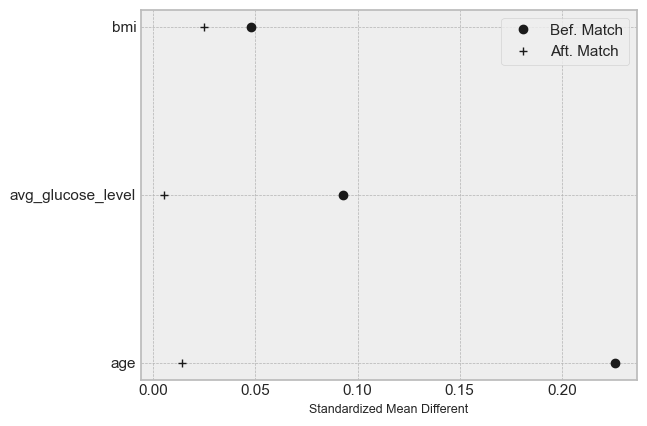

In [62]:
smd_plot(smd_before,smd_after)

# Distribution Plot After Matching

C:\Users\Lenovo V14-G2\AppData\Local\Temp\ipykernel_23724\2416855513.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_outliers['scaled_value'] = data_no_outliers['value']/max_value
C:\Users\Lenovo V14-G2\AppData\Local\Temp\ipykernel_23724\2416855513.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_outliers['scaled_value'] = data_no_outliers['value']/max_value
C:\Users\Lenovo V14-G2\AppData\Local\Temp\ipykernel_23724\2416855513.py:17: SettingWithCopyWarning: 
A value is trying to be s

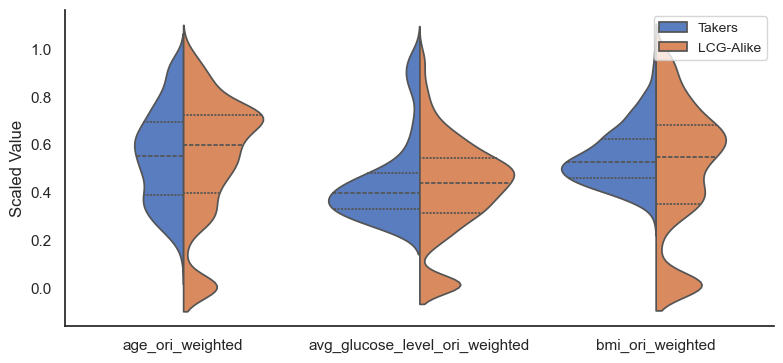

In [63]:
feature_kde_weighted = ['age_ori_weighted','avg_glucose_level_ori_weighted','bmi_ori_weighted']
kde_plot(df_matched,feature_kde_weighted,treatment,label_treatment={0: 'LCG-Alike', 1: 'Takers'})

# ATT

In [64]:
def predict_y0_y1(df, features, treatment, target, weight):
    df_temp = df.copy()
    
    # Preparation Features and Target
    df_temp['reversed_label'] = df_temp[treatment].apply(lambda b: abs(b-1))
    ols_features = features
    ols_features.insert(len(ols_features),treatment)
    ols_features.insert(len(ols_features),'reversed_label')
    X = df_temp[ols_features].values
    # print(X)
    y = df_temp[target].values
    

    # Fitting Model
    ols = LinearRegression()
    ols.fit(X, y)
    ols.score(X, y)
    
    # Reversing (0 1 to 1 0) to Predict Counter Factuals
    ols_features_reversed = features
    ols_features_reversed.insert(len(ols_features_reversed),'reversed_label')
    ols_features_reversed.insert(len(ols_features_reversed),treatment)
    X_reversed = df_temp[ols_features_reversed].values
    y_counter = ols.predict(X_reversed)
    y_counter = y_counter
    
    # print(X_reversed)

    # edit Variable Name
    counter = 'counter_{}'.format(target)
    y1 = 'Y1_{}'.format(target)
    y0 = 'Y0_{}'.format(target)
    y1_y0 = 'Y1_Y0_{}'.format(target)


    # Deterimining Counter, y0 and y1
    df_temp[counter] = y_counter

    # Predicting Y0, Y1, and Y0 - Y1
    df_temp[y1] = df_temp[target] * df_temp[treatment] + df_temp[counter] * df_temp['reversed_label']
    df_temp[y0] = df_temp[target] * df_temp['reversed_label'] + df_temp[counter] * df_temp[treatment]
    df_temp[y1_y0] = (df_temp[y1] - df_temp[y0]) * df_temp[weight]
    return df_temp.copy()

In [65]:
# setting Variable
target = 'smoking_status_smokes'
y1_y0 = 'Y1_Y0_{}'.format(target)


#
df_matched_att = predict_y0_y1(df_matched, feature_ori, treatment, target, 'weight')
df_matched_ate = predict_y0_y1(df_matched, feature_ori, treatment, target, 'weight_ate')
df_matched_atc = predict_y0_y1(df_matched, feature_ori, treatment, target, 'weight_atc')

# Calculating ATT,ATE,ATC
ATT = df_matched_att[df_matched_att[treatment]==1][[y1_y0]].mean().values
ATE = df_matched_ate[[y1_y0]].mean().values
ATC = df_matched_atc[df_matched_atc[treatment]==0][[y1_y0]].mean().values

print('ATT: {}'.format(ATT))
print('ATE: {}'.format(ATE))
print('ATC: {}'.format(ATC))

ATT: [0.8383311]
ATE: [0.26682105]
ATC: [0.15811867]
